/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_54973/4147036638.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitl

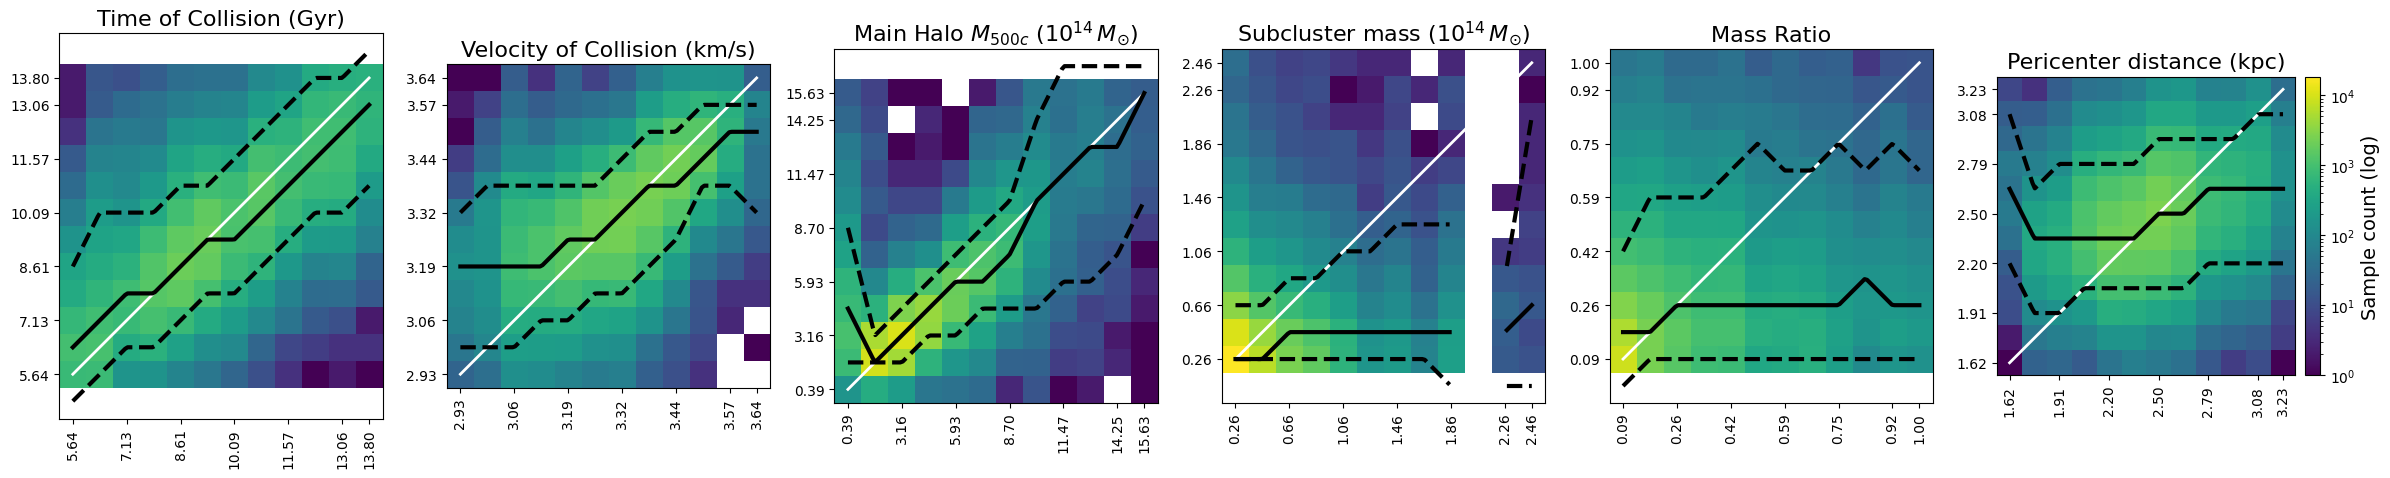

In [1]:
#!/usr/bin/env python3
import os
import re
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model import cINN

TARGET_COLS = [
        'Time of Collision (Gyr)',
        'Velocity of Collision (km/s)',
        r'Main Halo $M_{500c}$ ($10^{14} \, M_{\odot}$)',
        r'Subcluster mass ($10^{14} \, M_{\odot}$)',
        'Mass Ratio',
        'Pericenter distance (kpc)',
    ]

def normalize_key(fname):
    base = os.path.splitext(os.path.basename(fname))[0]
    m = re.match(r"^snap_(\d+)_halo_(\d+)_proj_\d+$", base)
    return f"{int(m.group(2))}_{int(m.group(1))}"

def load_test_projections(processed_dir, embeddings_npy, filenames_npy,
                          random_state=42, test_frac=0.1):
    # 1) load halo‐level CSVs and scalers
    dfX  = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY  = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_s_all = dfX.values
    Y_all   = dfY.values
    key2idx = { f"{int(r.HaloID)}_{int(r.Snapshot)}": i
                for i, r in meta.iterrows() }

    # 2) load all embeddings + filenames, filter to kept halos
    all_emb   = np.load(embeddings_npy)
    all_files = np.load(filenames_npy)
    proj_keys, Es = [], []
    for fn, emb in zip(all_files, all_emb):
        key = normalize_key(fn)
        if key in key2idx:
            proj_keys.append(key)
            Es.append(emb)
    E_proj_raw = np.vstack(Es)    # (6549, D_emb)

    # 3) replicate scalars+targets for each projection
    X_s_proj = np.vstack([ X_s_all[key2idx[k]] for k in proj_keys ])
    Y_proj   = np.vstack([   Y_all[key2idx[k]]   for k in proj_keys ])

    # 4) scale embeddings
    emb_sc = joblib.load(os.path.join(processed_dir, "emb_scaler.pkl"))
    E_proj = emb_sc.transform(E_proj_raw)

    # 5) combine
    X_all = np.hstack([X_s_proj, E_proj])
    Y_all = Y_proj

    # 6) split into train/test
    N = X_all.shape[0]
    idx = np.arange(N)
    idx_tmp, idx_test = train_test_split(idx, test_size=test_frac, random_state=random_state)
    X_test = X_all[idx_test]
    Y_test = Y_all[idx_test]
    keys_test = [proj_keys[i] for i in idx_test]

    return X_test, Y_test, keys_test

def plot_posteriors_all_targets(model_checkpoint: str,
                                processed_dir: str = "processed_data",
                                embeddings_npy: str = "embeddings.npy",
                                filenames_npy: str  = "filenames.npy",
                                n_samples_per_proj: int = 100,
                                random_state: int       = 42,
                                num_bins: int           = 10,
                                max_ticks: int          = 5):
    """
    For each target in TARGET_COLS, build a heatmap of
    prior‐bin vs. posterior‐bin counts (log scale).
    """
    # --- prepare data ---
    X_test, Y_test, keys_test = load_test_projections(
        processed_dir, embeddings_npy, filenames_npy,
        random_state=random_state, test_frac=0.1
    )
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N_test, _ = X_test.shape
    D_tar     = Y_test.shape[1]
    assert D_tar == len(TARGET_COLS)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # cINN expects y_dim, x_dim
    model = cINN(y_dim=D_tar, x_dim=N_test and X_test.shape[1], hidden_dim=128, n_blocks=12, clamp=2.0)
    ckpt  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.to(device).eval()

    # --- build priors/posteriors per target ---
    all_data = []
    results  = []
    Y_phys_test = tar_sc.inverse_transform(Y_test)

    for d in range(D_tar):
        # prior bins from truth
        truth = Y_phys_test[:, d]
        bins  = np.linspace(truth.min(), truth.max(), num_bins+1)
        # digitize assigns each sample to a bin index [0..num_bins-1]
        bin_idx = np.digitize(truth, bins[1:-1], right=False)

        # collect posterior samples per prior‐bin
        bin_to_post = {b: [] for b in range(num_bins)}
        with torch.no_grad():
            for i, b in enumerate(bin_idx):
                x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
                Z  = torch.randn(n_samples_per_proj, D_tar, device=device)
                inv = model.inverse(Z, x0.repeat(n_samples_per_proj, 1))
                Ys  = inv[0] if isinstance(inv, tuple) else inv
                phys = tar_sc.inverse_transform(Ys.cpu().numpy())[:, d]
                bin_to_post[b].append(phys)

        # fill count matrix & compute median,10th,90th bin indices
        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i  = np.full(num_bins, np.nan)
        lo_i   = np.full(num_bins, np.nan)
        hi_i   = np.full(num_bins, np.nan)

        for b in range(num_bins):
            samples = bin_to_post[b]
            if not samples: 
                continue
            arr = np.concatenate(samples)
            counts[b], _ = np.histogram(arr, bins=bins)
            med = np.median(arr)
            lo  = np.percentile(arr, 10)
            hi  = np.percentile(arr, 90)
            # map values back to bin‐indices
            med_i[b] = np.digitize(med, bins) - 1
            lo_i[b]  = np.digitize(lo,  bins) - 1
            hi_i[b]  = np.digitize(hi,  bins) - 1

        all_data.append(counts.T)  # transpose so x=prior, y=posterior
        results.append((counts.T, med_i, lo_i, hi_i, bins))

    # --- shared LogNorm scale ---
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat>0]
    vmin = max(1, pos.min() if pos.size else 1)
    vmax = flat.max()
    norm = LogNorm(vmin=vmin, vmax=vmax)

    # --- tick positions ---
    step = max(1, num_bins // max_ticks)
    ticks = np.arange(0, num_bins, step)
    if ticks[-1] != num_bins-1:
        ticks = np.append(ticks, num_bins-1)

    # --- plot grid + single colorbar ---
    fig, axes = plt.subplots(1, D_tar, figsize=(4*D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, bins = results[d]
        ends = bins[1:]

        im = ax.imshow(data, origin='lower', norm=norm,
                       aspect='equal', interpolation='nearest',
                       cmap='viridis')

        ax.plot([0, num_bins-1], [0, num_bins-1], 'w-', lw=2)
        xs = np.linspace(0, num_bins-1, num_bins*10)
        # smooth median / percentiles
        med_s = np.interp(xs, np.arange(num_bins), med_i)
        lo_s  = np.interp(xs, np.arange(num_bins), lo_i)
        hi_s  = np.interp(xs, np.arange(num_bins), hi_i)
        ax.plot(xs, med_s, '-', lw=3, color='k')
        ax.plot(xs, lo_s,  '--', lw=3, color='k')
        ax.plot(xs, hi_s,  '--', lw=3, color='k')

        ax.set_title(TARGET_COLS[d], fontsize=16)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{ends[i]:.2f}" for i in ticks], rotation=90)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{ends[i]:.2f}" for i in ticks])

    # colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax     = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax).set_label(
        "Sample count (log)", fontsize=14)

    plt.tight_layout()
    #fig.savefig("2.prediction_performance1.pdf", bbox_inches='tight')
    fig.savefig("2.prediction_performance1.png", bbox_inches='tight')
    plt.show()
    return results


if __name__ == "__main__":
    plot_posteriors_all_targets(
        model_checkpoint="best_cluster_cinn_combined.pt",
        processed_dir="processed_data",
        embeddings_npy="embeddings.npy",
        filenames_npy="filenames.npy",
        n_samples_per_proj=100,
        random_state=42,
        num_bins=12
    )


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_54973/3235834195.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitl

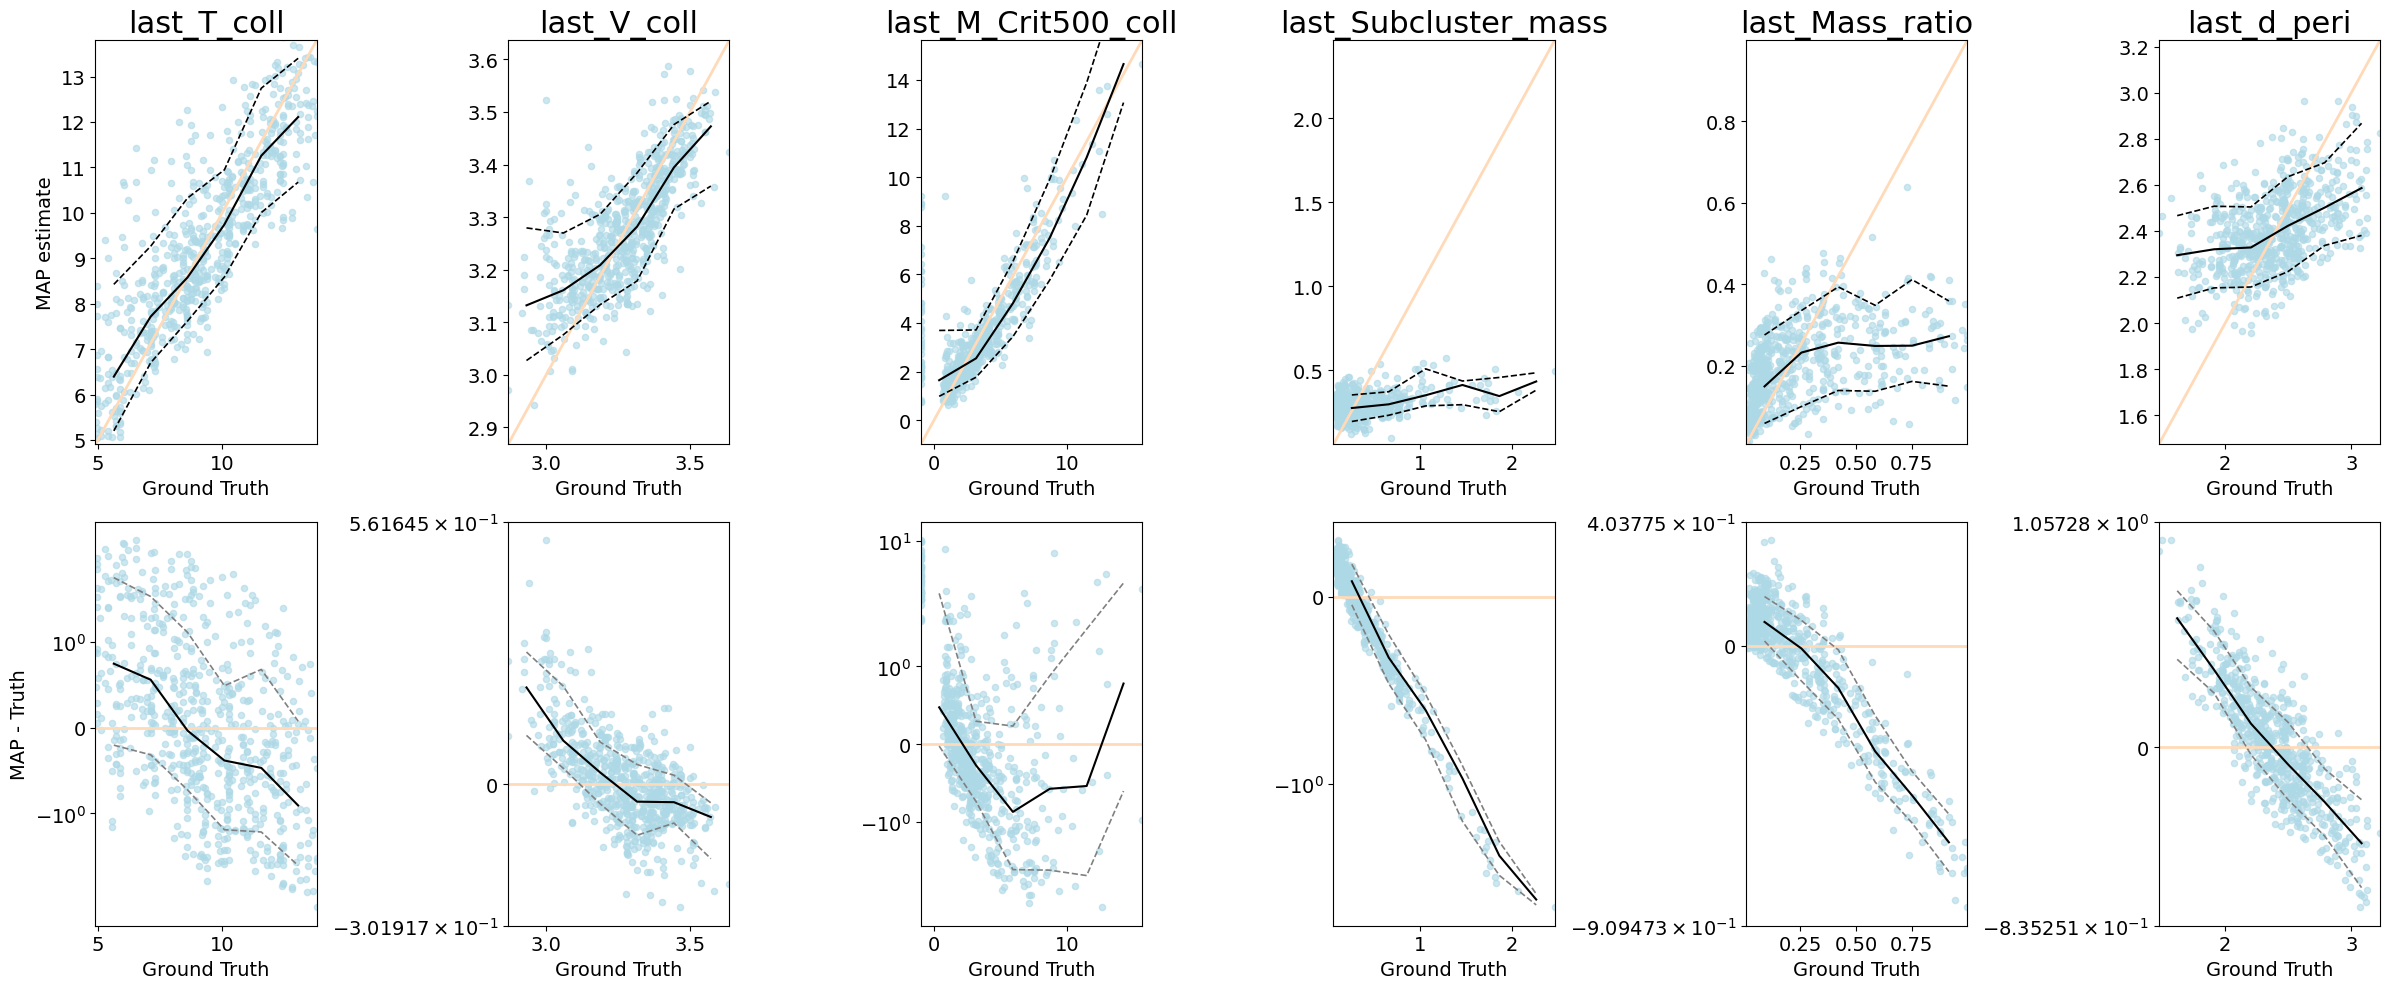

In [3]:
from sklearn.neighbors import KernelDensity


def normalize_key(fname):
    """
    "snap_050_halo_123456_proj_1.png" → "123456_50"
    """
    base = os.path.splitext(os.path.basename(fname))[0]
    m = re.match(r"^snap_(\d+)_halo_(\d+)_proj_\d+$", base)
    if not m:
        raise ValueError(f"Filename {fname} does not match expected pattern")
    snap, halo = m.group(1), m.group(2)
    return f"{int(halo)}_{int(snap)}"

def load_test_projections(processed_dir, embeddings_npy, filenames_npy,
                          test_frac=0.1, random_state=42):
    # 1) load CSV‐scaled scalars, targets, and meta
    dfX  = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY  = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_s_all = dfX.values          # (n_halos, D_obs)
    Y_all   = dfY.values          # (n_halos, D_tar)
    # map halo_snapshot → row index
    key2idx = {
        f"{int(r.HaloID)}_{int(r.Snapshot)}": i
        for i, r in meta.iterrows()
    }

    # 2) load all embeddings + filenames, filter to kept halos
    all_emb   = np.load(embeddings_npy)   # (n_projs_total, D_emb)
    all_files = np.load(filenames_npy)    # (n_projs_total,)
    proj_keys, Es = [], []
    for fn, emb in zip(all_files, all_emb):
        key = normalize_key(fn)
        if key in key2idx:
            proj_keys.append(key)
            Es.append(emb)
    E_proj_raw = np.vstack(Es)             # (n_projs_kept, D_emb)

    # 3) replicate scalar+target rows for each projection
    X_s_proj = np.vstack([ X_s_all[key2idx[k]] for k in proj_keys ])  # (n_projs_kept, D_obs)
    Y_proj   = np.vstack([   Y_all[key2idx[k]]   for k in proj_keys ])  # (n_projs_kept, D_tar)

    # 4) scale embeddings with saved scaler
    emb_sc = joblib.load(os.path.join(processed_dir, "emb_scaler.pkl"))
    E_proj = emb_sc.transform(E_proj_raw)  # (n_projs_kept, D_emb)

    # 5) combine and split
    X_all = np.hstack([X_s_proj, E_proj])  # (n_projs_kept, D_obs + D_emb)
    Y_all = Y_proj                         # (n_projs_kept, D_tar)
    N = X_all.shape[0]
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=test_frac, random_state=random_state)
    X_test = X_all[idx_test]
    Y_test = Y_all[idx_test]
    keys_test = [proj_keys[i] for i in idx_test]

    # also return target column names
    target_names = dfY.columns.tolist()
    return X_test, Y_test, keys_test, target_names

def plot_map_and_error_vs_truth(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    embeddings_npy: str = "embeddings.npy",
    filenames_npy: str  = "filenames.npy",
    n_posterior_samples: int = 600,
    num_bins: int           = 10,
    linthresh: float        = 0.1,
    random_state: int       = 42,
    label_fontsize: int     = 14,
    title_fontsize: int     = 22
):
    """
    Top:    truth vs MAP (with 10th/90th percentile bands)
    Bottom: truth vs (MAP - truth), symlog scale, with 16th/84th bands.
    """
    # load test projections and target names
    X_test, Y_test, keys_test, target_names = load_test_projections(
        processed_dir, embeddings_npy, filenames_npy,
        test_frac=0.1, random_state=random_state
    )
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N_test, D_obs_comb = X_test.shape
    _, D_tar = Y_test.shape
    assert D_tar == len(target_names)

    # invert Y_test to physical
    true_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)

    # load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(y_dim=D_tar, x_dim=D_obs_comb, hidden_dim=128, n_blocks=12, clamp=2.0)
    ckpt  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.to(device).eval()

    # compute MAP for each test point
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())  # (n_samples, D_tar)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # set up figure
    fig, axes = plt.subplots(2, D_tar, figsize=(4 * D_tar, 10), squeeze=False)

    # bin edges and centers for all targets
    for d in range(D_tar):
        truth = true_phys[:, d]
        mapv  = maps_phys[:, d]
        err   = mapv - truth

        tmin, tmax = truth.min(), truth.max()
        bins = np.linspace(tmin, tmax, num_bins + 1)
        centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1
        inds = np.clip(inds, 0, num_bins - 1)

        # compute percentile bands for MAP
        med_map = np.full(num_bins, np.nan)
        lo_map  = np.full(num_bins, np.nan)
        hi_map  = np.full(num_bins, np.nan)
        for b in range(num_bins):
            sel = mapv[inds == b]
            if sel.size:
                med_map[b] = np.median(sel)
                lo_map[b], hi_map[b] = np.percentile(sel, [10, 90])

        # top row: truth vs MAP
        ax = axes[0, d]
        ax.scatter(truth, mapv, s=20, alpha=0.6, color='lightblue')
        ax.plot([tmin, tmax], [tmin, tmax], color='peachpuff', lw=2)
        ax.plot(centers, med_map, '-',  lw=1.5, color='black')
        ax.plot(centers, lo_map,  '--', lw=1.2, color='black')
        ax.plot(centers, hi_map,  '--', lw=1.2, color='black')
        ax.set_xlim(tmin, tmax); ax.set_ylim(tmin, tmax)
        ax.set_title(target_names[d], fontsize=title_fontsize)
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP estimate", fontsize=label_fontsize)
        ax.tick_params(labelsize=label_fontsize)

        # bottom row: truth vs error
        # compute percentile bands for error
        med_err = np.full(num_bins, np.nan)
        lo_err  = np.full(num_bins, np.nan)
        hi_err  = np.full(num_bins, np.nan)
        for b in range(num_bins):
            sel = err[inds == b]
            if sel.size:
                med_err[b] = np.median(sel)
                lo_err[b], hi_err[b] = np.percentile(sel, [16, 84])

        ax = axes[1, d]
        ax.scatter(truth, err, s=20, alpha=0.6, color='lightblue')
        ax.axhline(0, color='peachpuff', lw=2)
        ax.plot(centers, med_err, '-',  lw=1.5, color='black')
        ax.plot(centers, lo_err,  '--', lw=1.2, color='gray')
        ax.plot(centers, hi_err,  '--', lw=1.2, color='gray')
        ax.set_yscale("symlog", linthresh=linthresh)
        ax.set_xlim(tmin, tmax)
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP - Truth", fontsize=label_fontsize)
        ax.tick_params(labelsize=label_fontsize)

    plt.tight_layout()
    #fig.savefig("2.prediction_performance2.pdf", bbox_inches='tight')
    fig.savefig("2.prediction_performance2.png", bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    plot_map_and_error_vs_truth(
        model_checkpoint="best_cluster_cinn_combined.pt",
        processed_dir="processed_data",
        embeddings_npy="embeddings.npy",
        filenames_npy="filenames.npy",
        n_posterior_samples=100,
        num_bins=6,
        linthresh=1.5,
        random_state=42
    )
